In [289]:
!pip install tslearn

import os
import keras
import tensorflow as tf
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import pylab as plt
import pandas as pd
import glob
import math
import cv2
import pickle
import umap

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean, cityblock
from math import cos, pi

from matplotlib import cm
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.linear_assignment_ import linear_assignment

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from tslearn.clustering import KShape

from math import sqrt
from scipy import stats
from scipy.cluster import vq
from scipy.spatial.distance import cdist
from sklearn.datasets.samples_generator import make_blobs

from tensorflow.python.keras.backend import eager_learning_phase_scope
from keras.engine.topology import Layer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, BatchNormalization, Reshape, LeakyReLU,Conv1D, UpSampling1D, MaxPooling1D, Conv1DTranspose, ELU, Dropout,MaxPooling2D, UpSampling2D, concatenate,Activation
from keras.layers import Input
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import load_img, array_to_img, img_to_array, ImageDataGenerator
from keras import optimizers


np.set_printoptions(threshold=np.inf) #...없이 출력하기

# 함수

Data Proprocessing(0) : CSV로부터 DATA 입력받기

In [306]:
# 데이터 입력 함수

"""
path : csv 파일의 경로
outlier_flag : 정규화 종류 (1 : 이상치 제거 / 0 : 이상치 보존)
value_col : 데이터를 나타내는 칼럼명
process_col : 데이터를 구분하는 칼럼명
"""

def align_timeseries_dataset(path,outlier_flag, value_col,process_col=None):

  if path==None or value_col == None:
    return

  input_csv = pd.read_csv(path,engine='python',encoding='utf-8')
  input_csv = input_csv.astype({value_col:'float32'})

  # outlier 제거 (Z-SCORE (-2~2) 사이만 남겨둠(95%))

  if outlier_flag == '1':

    input_csv['zscore'] = stats.zscore(input_csv[value_col])
    zscore_dataset = z_score_normalize(input_csv[value_col])

    input_csv = input_csv[input_csv['zscore'].between(-2,2)]
  
  minmax_dataset = min_max_normalize(input_csv[value_col])
  
  # min-max normalization 
  for i in range(len(minmax_dataset)):
    input_csv[value_col][i]=minmax_dataset[i]

  # Process가 존재하지 않는 경우
  if process_col == None:
    dataset = input_csv[value_col]
  
  # Process가 존재하는 경우 process 별로 데이터 분리
  else:
    dataset = []
    process_set = list(set(input_csv[process_col]))

    for process in process_set:
      data = input_csv[(input_csv[process_col]==process)]
      data = data[value_col]
      dataset.append(data)
  
  return np.array(dataset)

Data preprocessing function(1) - 시계열 데이터 길이 조절(truncation, padding, sliding window, DTW 등)

In [291]:
# 데이터 자르기 함수

def data_truncation(dataset):
  
  return_dataset = []
  max_size = 0
  min_size = 999999

  for i in range(len(dataset)):
    if dataset[i].size < min_size:
      min_size=dataset[i].size

  for i in range(len(dataset)):
    if dataset[i].size > min_size:
      return_dataset.append(dataset[i][:min_size])
    else:
      return_dataset.append(dataset[i])

  return np.array(return_dataset)

# 데이터 패딩 함수

def data_padding(dataset):

  return_dataset = []
  max_size = 0

  for i in range(len(dataset)):
    if dataset[i].size > max_size:
      max_size=dataset[i].size

  for i in range(len(dataset)):
    if dataset[i].size < max_size:
      return_dataset.append(np.pad(dataset[i], (0,max_size-dataset[i].size), 'constant', constant_values=0))
    else:
      return_dataset.append(dataset[i])

  return np.array(return_dataset)

# Sliding window 함수

def sliding_window(dataset, window_size = 10 , shift_size = 1):

  dataset = tf.data.Dataset.from_tensor_slices(dataset)
  dataset = dataset.window(window_size, shift=shift_size, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  return_dataset = list()

  for window in dataset:
    return_dataset.append(window.numpy())
  return_dataset = np.array(return_dataset)

  return return_dataset

# DTW 유사도를 통한 시계열 데이터 확장 함수 (작은 길이를 큰 길이로 맞춤)

def data_dtw(dataset):

  return_dataset = []
  max_size = 0
  max_index = 0

  for i in range(len(dataset)):
    if dataset[i].size > max_size:
      max_size=dataset[i].size
      max_index=i

  long_ts_data = dataset[max_index]

  for i in range(len(dataset)):
    if dataset[i].size < max_size:
      return_dataset.append(DTW_resize_algorithm(long_ts_data,dataset[i])[0])
    else:
      return_dataset.append(dataset[i])

  return np.array(return_dataset)


def DTW_resize_algorithm(long_ts_data, short_ts_data):

  if len(long_ts_data) == len(short_ts_data):
    return np.array(short_ts_data), np.array([0]*len(short_ts_data))

  step = 0
  similarity_degree_path = [0]*len(long_ts_data)
  long_ts_data = np.array(long_ts_data)
  short_ts_data = np.array(short_ts_data)

  path_coordinates = fastdtw(short_ts_data, long_ts_data)[1]

  for i in range(len(similarity_degree_path)):

    similarity_degree_path[i] = (long_ts_data[path_coordinates[step][1]]-short_ts_data[path_coordinates[step][0]])
    
    for j in range(step+1,len(path_coordinates)):

      if path_coordinates[step][1] == path_coordinates[j][1]:
        similarity_degree_path[i] = similarity_degree_path[i] + (long_ts_data[path_coordinates[j][1]]-short_ts_data[path_coordinates[j][0]])
        step=j
        continue

      else:
        step+=1
        break
        
  resize_ts_data = (long_ts_data - similarity_degree_path)

  return np.array(resize_ts_data), np.array(similarity_degree_path)

Data preprocessing function(2) - 데이터 정규화 or 일반화

In [292]:
# Min-Max Normalization: 모든 feature들의 스케일이 동일하지만, 이상치(outlier)를 잘 처리하지 못한다.

def min_max_normalize(lst):
    normalized = []
    
    min_value = min(lst)
    max_value = max(lst)

    for value in lst:
        normalized_num = (value - min_value) / (max_value -min_value)
        normalized.append(normalized_num)
    
    return np.array(normalized)

# Z-Score Normalization : 이상치(outlier)를 잘 처리하지만, 정확히 동일한 척도로 정규화 된 데이터를 생성하지는 않는다.

def z_score_normalize(lst):
    normalized = []

    mean_value = np.mean(lst)
    std_value = np.std(lst)
    
    for value in lst:
        normalized_num = (value - mean_value) / std_value
        normalized.append(normalized_num)
    return np.array(normalized)

Data preprocessing function(3) - 잠재 벡터 추출(UMAP, 이미지화 등)

In [293]:
"""
RP 알고리즘

serialize_vector : 시계열 데이터 value vector
"""

def RP_algorithm(serialize_vector):

    N = serialize_vector.size
    S = np.repeat(serialize_vector[None,:],N,axis=0)
    Z = np.abs(S-S.T)
    Z/=Z.max()
    Z*=255
    Z = Z.astype('uint8')
    Z = np.array(Z)
    return Z

"""

GAF 알고리즘 

"""

def tabulate(x, y, f):
    """Return a table of f(x, y). Useful for the Gram-like operations."""
    return np.vectorize(f)(*np.meshgrid(x, y, sparse=True))
def cos_sum(a, b):
    """To work with tabulate."""
    return(math.cos(a+b))

class GAF_algorithm:

    def __init__(self):
        pass
    def __call__(self, serie):
        """Compute the Gramian Angular Field of an image"""
        # Min-Max scaling
        min_ = np.amin(serie)
        max_ = np.amax(serie)
        scaled_serie = (2*serie - max_ - min_)/(max_ - min_)

        # Floating point inaccuracy!
        scaled_serie = np.where(scaled_serie >= 1., 1., scaled_serie)
        scaled_serie = np.where(scaled_serie <= -1., -1., scaled_serie)

        # Polar encoding
        phi = np.arccos(scaled_serie)
        # Note! The computation of r is not necessary
        r = np.linspace(0, 1, len(scaled_serie))

        # GAF Computation (every term of the matrix)
        gaf = tabulate(phi, phi, cos_sum)

        gaf = (1+gaf)*255/2.0

        return gaf

"""
image_vector : 변경하고자 하는 이미지 리스트
img_size : 변경하고자 하는 이미지 크기
"""

def resize_img(image_vector_list, img_size):

  image_list = []
  
  for i in range(len(image_vector_list)):

    if len(image_vector_list[i]) > img_size:
      img = cv2.resize(image_vector_list[i],(img_size,img_size),interpolation = cv2.INTER_AREA)

    else:
      img = cv2.resize(image_vector_list[i],(img_size,img_size),interpolation = cv2.INTER_LINEAR)

    img = img.astype('uint8')
    image_list.append(img)

  image_list = np.array(image_list)

  return image_list

In [294]:
# Auto_Encoder 함수

"""

dataset : (n,) shape의 데이터
LEARNING_LATE : 러닝레이트
BATCH_SIZE : 배치사이즈
EPOCHS : 에폭
IMAGE
TEST_SIZE : traing에서 뽑아낼 test 사이즈(default = 100)
IMG_SIZE : 이미지사이즈(default = 64)
IMAGING_FLAG : 이미지화 방법 (True : RP / False : GAF)
IMAGE_SIZE_FLAG = 이미지 크기 (1 : small / 2 : middle / 3: large)
"""

def embedding_AE(dataset,LEARNING_LATE,BATCH_SIZE,EPOCHS,IMAGING_FLAG,IMAGE_SIZE_FLAG='1',TEST_SIZE=100):
  
  np.random.seed(1)
  tf.random.set_seed(1)

  latent_dim = 2

  # 시계열데이터 이미지화

  dataset_img = []

  if IMAGING_FLAG == '1':
    for i in range(len(dataset)):
      dataset_img.append(RP_algorithm(dataset[i]))
  else:
    gaf = GAF_algorithm()

    for i in range(len(dataset)):
      dataset_img.append(gaf(dataset[i]))

  if IMAGE_SIZE_FLAG == '1':
    IMG_SIZE = 64
  elif IMAGE_SIZE_FLAG == '2':
    IMG_SIZE = 128
  else :
    IMG_SIZE = 256

  dataset_class_img = resize_img(dataset_img,IMG_SIZE)
  dataset_class_img = np.array(dataset_class_img)

  dataset_image = dataset_class_img.reshape(len(dataset),IMG_SIZE,IMG_SIZE)

  # Image -> train / test로 나누기

  train = dataset_image
  np.random.shuffle(train)

  train = train.reshape(-1,IMG_SIZE,IMG_SIZE,1)

  test = train[len(train)-TEST_SIZE:]
  train = train[:len(train)-TEST_SIZE]  

  # 데이터 정규화

  train = train/dataset_image.max()
  test = test/dataset_image.max()

  # 체크포인트 설정

  ae_checkpoint_path = 'AE.ckpt'
  ae_checkpoint_dir = os.path.dirname(ae_checkpoint_path)

  ae_callback_early = keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=0,
            patience=50,
            verbose=0,
            mode='auto'
  )

  ae_callback_best = keras.callbacks.ModelCheckpoint(
    filepath=ae_checkpoint_path,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq=1
    )
  
  # AE Layer 설정

  encoder_input = Input(shape=(IMG_SIZE,IMG_SIZE,1), name='input')

  x = Conv2D(16, 3,strides=2, padding='same',activation='relu')(encoder_input)
  x = BatchNormalization()(x)

  x = Conv2D(32, 3, strides=2, padding='same',activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(64, 3, strides=2,padding='same',activation='relu')(x)
  x = BatchNormalization()(x)

  x = Flatten()(x)
  units = x.shape[1]

  # 2D 좌표로 표기하기 위하여 2를 출력값으로 지정
  embed = Dense(latent_dim,name='embedded')(x)

  x = Dense(units)(embed)
  x = Reshape((8, 8, 64))(x)

  x = Conv2DTranspose(64, 3, strides=1, padding='same',activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(32, 3, strides=2, padding='same',activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(16, 3, strides=2, padding='same',activation='relu')(x)
  x = BatchNormalization()(x)

  decoder_outputs = Conv2DTranspose(1, (3,3), strides=2, padding='same', activation='sigmoid',name='output')(x)

  # 오토인코더 실행

  autoencoder = Model(encoder_input, decoder_outputs)
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_LATE), loss=tf.keras.losses.MeanSquaredError())

  hist = autoencoder.fit(train, train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data =(test,test),shuffle=True,callbacks=[ae_callback_early,ae_callback_best])

  # 이미지 그리기

  decoded_images = autoencoder.predict(test)

  draw_image_data(test,"Original Image",IMG_SIZE)
  draw_image_data(decoded_images,"Reproduction Image",IMG_SIZE)

  # 인코딩된 잠재 벡터 

  get_embedded = K.function([autoencoder.get_layer('input').input],
                                  [autoencoder.get_layer('embedded').output])
  
  dataset_dimension = np.vstack(get_embedded([dataset_image]))
  dataset_dimension_data = np.vstack([dataset_dimension])
  dataset_dimension_data = dataset_dimension_data.reshape(-1,latent_dim)

  return dataset_dimension_data

In [295]:
# UMAP 함수

"""
n_components : 축소하고자 하는 차원수
n_neighbors : 작을수록 locality를 잘 나타내고, 커질수록 global structure를 잘 나타냄
"""

def embedding_UMAP(dataset, components=2, neighbors=50):
  reducer = umap.UMAP(n_components=2,n_neighbors=50,init='random',random_state=0)
  embedding = reducer.fit_transform(dataset)
  return embedding

In [296]:
# PCA 함수
"""
n_component : 주성분 분석 개수
반환값 : PCA 실행 결과 
"""

def embedding_PCA(dataset, n_component=2):
  pca = PCA(n_components=n_component)
  pca.fit(dataset)
  dataset_pca = pca.transform(dataset)
  #print(pca.explained_variance_ratio_)
  return dataset_pca

Clustering

In [297]:
# K-means 함수

"""
dimension_data=잠재벡터
MAX_CLUSTER_SIZE=최대 군집 개수
"""

def clustering_KMEANS(dimension_data,MAX_CLUSTER_SIZE = 10) : 
  #class_dimension_data=잠재벡터,num_cluster=최대 군집 개수

  n_cluster_list = cal_Silhouette(dimension_data,MAX_CLUSTER_SIZE,5)
  #best_cluster = n_cluster_list[0]

  dimension_data = dimension_data.reshape(-1,2)

  for center in n_cluster_list:
    draw_cluster_and_center(dimension_data,center)

In [298]:
# K-shape 함수

"""
timeseries_data=
n_cluster=군집 수
"""

def clustering_KSHAPE(timeseries_data,n_cluster=2) : 

  ks = KShape(n_clusters=n_cluster)
  cluster_found_kshape = ks.fit_predict(timeseries_data)

  return cluster_found_kshape

In [299]:
# DBSCAN 함수 
"""
eps : 기준점으로부터의 거리
min_samples : 반경 내의 점의 개수
반환값 : dbscan 군집 결과
"""

def clsutering_DBSCAN(dataset,eps, min_samples):
  dbscan = DBSCAN(eps = eps, min_samples= min_samples)
  predict = dbscan.fit_predict(dataset)

  max = predict.max()
  
  for i in range(len(dataset)):
    if predict[i]== -1:
      predict[i]= max+1
      
  return predict 

In [300]:
# ISODATA 함수

def initialize_parameters(parameters=None):
  # 파라미터 값 지정하기
    parameters = {} if not parameters else parameters

    def safe_pull_value(parameters, key, default):
        return parameters.get(key, default)

    # 대략적으로 요구되는 군집 수 (실루엣 값 입력)
    K = safe_pull_value(parameters, 'K', 7)

    # 최대 Iteration 횟수
    I = safe_pull_value(parameters, 'I', 100)

    # maximum of number of pairs of clusters which can be merged : 결합될 수 있는 최대 군집 수
    P = safe_pull_value(parameters, 'P', 2)

    # 군집을 만드는 최소 표본의 개수
    THETA_M = safe_pull_value(parameters, 'THETA_M', 20)
    # threshold value for standard deviation (for split) Split을 위한 표준편차 (최대 분산 파라미터)
    THETA_S = safe_pull_value(parameters, 'THETA_S', 1)
    # threshold value for pairwise distances (for merge) Merge가 요구되는 최대 분리 거리
    THETA_C = safe_pull_value(parameters, 'THETA_C', 5)

    # Iteration 당 Cluster의 변화율
    THETA_O = 0.05

    # 클러스터 개수의 초기값 설정(random or K)
    #k = np.random.randint(1, K)
    k = safe_pull_value(parameters, 'k', K)

    ret = locals()
    ret.pop('safe_pull_value')
    ret.pop('parameters')
    # 지역변수를 전역변수로 올려주는 역할
    globals().update(ret) 


def initial_clusters(img, k):

    """
    초기 클러스터 임의 설정
    """
    np.random.shuffle(img)
    centers = img[0:k]
    
    return centers

def discard_clusters(img_class, centers, clusters_list):

    """
      최소 표본을 만족하지 못한 cluster center 폐기
    """

    k = centers.shape[0]
    to_delete = np.array([0])

    for cluster in range(0, k):
        indices = np.where(img_class == clusters_list[cluster])[0]
        total_per_cluster = indices.size

        if total_per_cluster <= THETA_M:
            to_delete = np.append(to_delete, cluster)
    if to_delete.size:
        new_centers = np.delete(centers, to_delete, axis=0)
        new_clusters_list = np.delete(clusters_list, to_delete)
    else:
        new_centers = centers
        new_clusters_list = clusters_list

    return new_centers, new_clusters_list


def update_clusters(img, img_class, centers, clusters_list):
    cluster = centers.shape[0]

    for i in range(cluster):
        indices = np.where(img_class == clusters_list[i])[0]
        cluster_values = img[indices]
        centers[i] = tf.reduce_mean(cluster_values, axis=0)

    return centers

def split_clusters(img, img_class, centers, clusters_list):
    cluster = centers.shape[0]
    varicance = []
    #sigma = 10

    for i in clusters_list:
        indices = np.where(img_class == clusters_list[i])[0]
        cluster_values = img[indices]
        number = indices.size
        varicance = np.var(cluster_values, axis=0)
        var_max = varicance[np.argmax(varicance)]

        if var_max > THETA_S and number > 2*THETA_M:
            clusters_list = np.append(clusters_list, clusters_list.size)
            a = np.zeros(centers.shape[1])
            b = a + var_max
            centers[i] = centers[i] - b
            centers = np.append(centers, [centers[i] + b], axis=0)

    return centers, clusters_list


def merge_clusters(img_class, centers, clusters_list):
    pair_dists = []
    size = centers.shape[1]

    for i in range(0, size):
        for j in range(0, size):
            if i > j:
                d = sqrt(cdist([centers[i]], [centers[j]], metric= 'sqeuclidean'))
                pair_dists.append((d, (i, j)))
    first_p_elements = pair_dists[:P]
    below_threshold = [(c1, c2) for d, (c1, c2) in first_p_elements if d < THETA_C]

    if below_threshold:
        k = centers.shape[1]
        count_per_cluster = np.zeros(k)
        # new clusters to add
        to_add = np.array([]) 
        # clusters to delete
        to_delete = np.array([])  

        for cluster in range(0, k):
            result = np.where(img_class == clusters_list[cluster])
            indices = result[0]
            count_per_cluster[cluster] = indices.size

        for c1, c2 in below_threshold:
            c1_count = float(count_per_cluster[c1])
            c2_count = float(count_per_cluster[c2])
            factor = 1.0 / (c1_count + c2_count)
            weight_c1 = c1_count * centers[c1]
            weight_c2 = c2_count * centers[c2]

            value = factor * (weight_c1 + weight_c2)

            to_add = np.append(to_add, value)
            to_delete = np.append(to_delete, [c1, c2])

            # delete old clusters and their indices from the availables array
            centers = np.delete(centers, to_delete, axis=0)
            clusters_list = np.delete(clusters_list, to_delete)

            # generate new indices for the new clusters
            # starting from the max index 'to_add.size' times
            start = int(clusters_list.max())
            end = to_add.size + start

            centers = np.append(centers, to_add, axis=0)
            clusters_list = np.append(clusters_list, range(start, end))
            #centers, clusters_list = sort_arrays_by_first(centers, clusters_list)

    return centers, clusters_list


def clustering_ISODATA(dataset, parameters=None):
    global K, I, P, THETA_M, THETA_S, THETA_C, THETA_O, k
    initialize_parameters(parameters)
    #clusters_list = np.arange(k)  # number of clusters availables
    centers = initial_clusters(dataset, k)

    for iter in range(0, I):
        #last_centers = centers.copy()
        # assing each of the samples to the closest cluster center
        
        k = centers.shape[0]
        clusters_list = np.arange(k)
        img_class, dists = vq.vq(dataset, centers)
        centers, clusters_list = discard_clusters(img_class, centers, clusters_list)

        k = centers.shape[0]
        clusters_list = np.arange(k)
        img_class, dists = vq.vq(dataset, centers)
        centers = update_clusters(dataset, img_class, centers, clusters_list)
        
        k = centers.shape[0]
        if k <= (K / 2.0):
            centers, clusters_list = split_clusters(dataset, img_class,centers, clusters_list)
        elif k > (K * 2.0):
            centers, clusters_list = merge_clusters(img_class, centers,clusters_list)
        else:
            pass
        img_class, dists = vq.vq(dataset, centers)

    return img_class

기타 함수

In [301]:
# 실루엣 다이어그램 그리는 함수

def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    plt.axvline(silhoutte_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('K')
    plt.xlabel('Silhouette value')
    plt.show()


#  실루엣 계수 계산 함수
#  max_cluster_num : 최대 클러스터 개수(k)
#  cluster_num : 추출할 실루엣 계수 높은 클러스터 개수

def cal_Silhouette(data,max_cluster_num,cluster_num):
  max = []

  for i in range(2,max_cluster_num+1):
    km=KMeans(n_clusters=i,random_state=10)
    km_labels = km.fit_predict(data)
    max.append([i,silhouette_score(data, km_labels)])
    
    max.sort(key=lambda x:x[1],reverse=True)
  print(max)
# 실루엣 계수 높은 상위 (clust_num)개만 추출해서 클러스터 개수 저장
  n_cluster_list=[]

  for i in max[0:cluster_num]:
    n_cluster_list.append(i[0])

  return n_cluster_list

def draw_inertia_kshape(dimension_data,MAX_CLUSTER_SIZE=10):

  distortions_kshape = []

  for i in range(2,MAX_CLUSTER_SIZE+1):
    
    kshape = KShape(n_clusters=i, max_iter=100)
    cluster_found = kshape.fit_predict(dimension_data)
    distortions_kshape.append(kshape.inertia_)

  plt.plot(range(2,MAX_CLUSTER_SIZE+1), distortions_kshape, marker='o')
  plt.xlabel('Number of clusters')
  plt.ylabel('Distortion')
  plt.show()

"""
cluster_list 의 k 값으로 실루엣 다이어그램 작성 함수

"""

def draw_Silhouette_Diagram(data, n_cluster_list):
  for i in range(len(n_cluster_list)):
    print("Cluster 개수 : ",n_cluster_list[i])
    
    km=KMeans(n_clusters=n_cluster_list[i],random_state=10)
    km_labels = km.fit_predict(data)
    plotSilhouette(data,km_labels)

"""
center : cluster center 수
data : cluster data
"""

def draw_cluster_and_center(data,center):
  Kmean=KMeans(n_clusters=center)
  Kmean.fit(data)

  plt.scatter(data[:,0],data[:,1],s=0.05,c=Kmean.labels_.astype(float))

  print("Center 개수 : ",center)
  for i in range(center):
    plt.scatter(Kmean.cluster_centers_[i,0],Kmean.cluster_centers_[i,1],s=50,c='red',marker='s')

  plt.show()

In [302]:
# 시계열 데이터 그리는 함수

"""
dimenstion_data : 2차원의 데이터
predict : 라벨 번호 list (정답)
label : 라벨 이름 list

"""
def draw_vector_data(dimenstion_data, predict=None,label=None):

  plt.figure(figsize=(15,15))
  plt.rc('legend', fontsize='20')

  if predict is not None:

    #n_clusters = set(predict)
    #color = cm.rainbow(np.linspace(0, len(n_clusters), dimenstion_data.shape[0]))
    
    if label is None:
      plt.scatter(dimenstion_data[:,0],dimenstion_data[:,1],s=30,c=predict)
        
    else : 
      plt.scatter(dimenstion_data[0],dimenstion_data[1],s=30,label=label,c=predict)

  else:
    plt.scatter(dimenstion_data[:,0],dimenstion_data[:,1],s=30,color='blue')



In [303]:
# 이미지 데이터 그리는 함수

"""
image_data : 이미지 데이터
title : 제목

n_images : 그릴 이미지 수
IMG_SIZE : reshape할 이미지 사이즈(image_data의 크기와 반드시 같아야함)

"""

def draw_image_data(image_data ,title ,n_images=5, IMG_SIZE=64) :

  plt.figure(figsize=(100, 10))
  
  for i in range(n_images):
    ## display original
    ax = plt.subplot(1, n_images, i + 1)
    ax.set_title("Original Image")
    plt.imshow(image_data[i].reshape(IMG_SIZE, IMG_SIZE))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# ① 데이터 전처리

csv로 부터 데이터 받아오기

In [307]:
# Path를 받아와서 csv 데이터 상위 10개를 보여줌

dataset = None
embedding_data = None
predict = None

path = input("PATH : ")

process_flag = input("Process (존재시 1, 존재하지 않을 시 0) : ")
outlier_flag = input("Outlier (이상치 제거O : 1 / 이상치 제거X : 0) : ")  

if process_flag=='1':
  value_col = input("Value Column : ")
  process_col = input('Process Column: ')
  dataset = align_timeseries_dataset(path,outlier_flag, value_col,process_col)
  
else:
  value_col = input("Value Column : ")
  dataset = align_timeseries_dataset(path,outlier_flag,value_col)

PATH : ./Dataset2.csv
Process (존재시 1, 존재하지 않을 시 0) : 1
Outlier (이상치 제거O : 1 / 이상치 제거X : 0) : 0
Value Column : Value
Process Column: Process


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [308]:
dataset.shape

(242,)

In [ ]:
dataset.max()

데이터 cutting


In [309]:
preprocessing_flag = 0

preprocessing_flag = int(input("Data preprocessing( 1 : sliding window / 2 : trunction / 3 : padding / 4 : DTW) : "))

# 1 : sliding window / 2 : trunction / 3 : padding / 4: DTW
# 지금은 일단 1로만 가능

if preprocessing_flag == 1:
  shift_size = int(input('Shift length : '))
  window_size = int(input('Window size : '))

  dataset = sliding_window(dataset,window_size,shift_size)

elif preprocessing_flag == 2:
  dataset = data_truncation(dataset)

elif preprocessing_flag == 3:
  dataset = data_padding(dataset)

elif preprocessing_flag == 4:
  dataset = data_dtw(dataset)

else :
  pass

Data preprocessing( 1 : sliding window / 2 : trunction / 3 : padding / 4 : DTW) : 2


In [310]:
dataset.shape

(242, 163)

#② 잠재 벡터 추출

Embedding (1 : Auto Encoder / 2 : PCA / 3 : UMAP) : 3


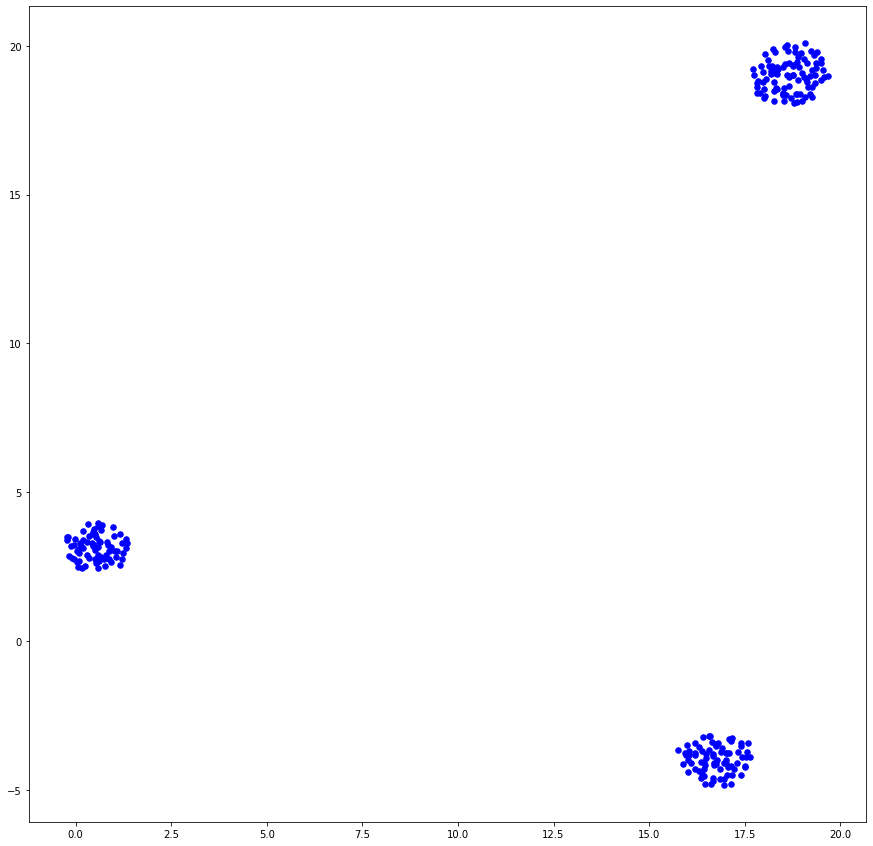

In [311]:
embedding_flag = 0

embedding_flag = int(input("Embedding (1 : Auto Encoder / 2 : PCA / 3 : UMAP) : "))

# 1 : Auto Encoder / 2 : PCA / 3 : UMAP

if embedding_flag == 1:

  LEARNING_LATE = float(input('LEARNING_LATE : '))
  BATCH_SIZE = int(input('BATCH_SIZE : '))
  EPOCHS = int(input('EPOCHS : '))
  IMAGING_FLAG = input("IMAGING (1 : RP / 2 : GAF) : ")
  IMAGE_SIZE_FLAG = input("IMAGE SIZE (1 : small / 2 : middle / 3: large) : ")

  embedding_data = embedding_AE(dataset,LEARNING_LATE,BATCH_SIZE,EPOCHS,IMAGING_FLAG,IMAGE_SIZE_FLAG)
  
elif embedding_flag == 2:
  embedding_data = embedding_PCA(dataset)

elif embedding_flag == 3:
  embedding_data = embedding_UMAP(dataset)

else :
  pass

draw_vector_data(embedding_data)

#③ 클러스터링

Clustering (1 : K-menas / 2: K-shape / 3 : DBSCAN / 4 : ISODATA) :  2
MAX_CLUSTER_SIZE : 10


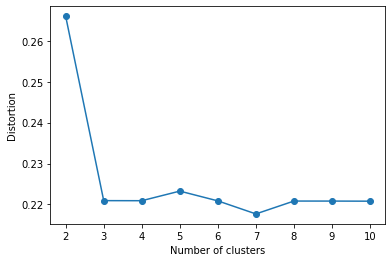

N_CLUSTERS : 3


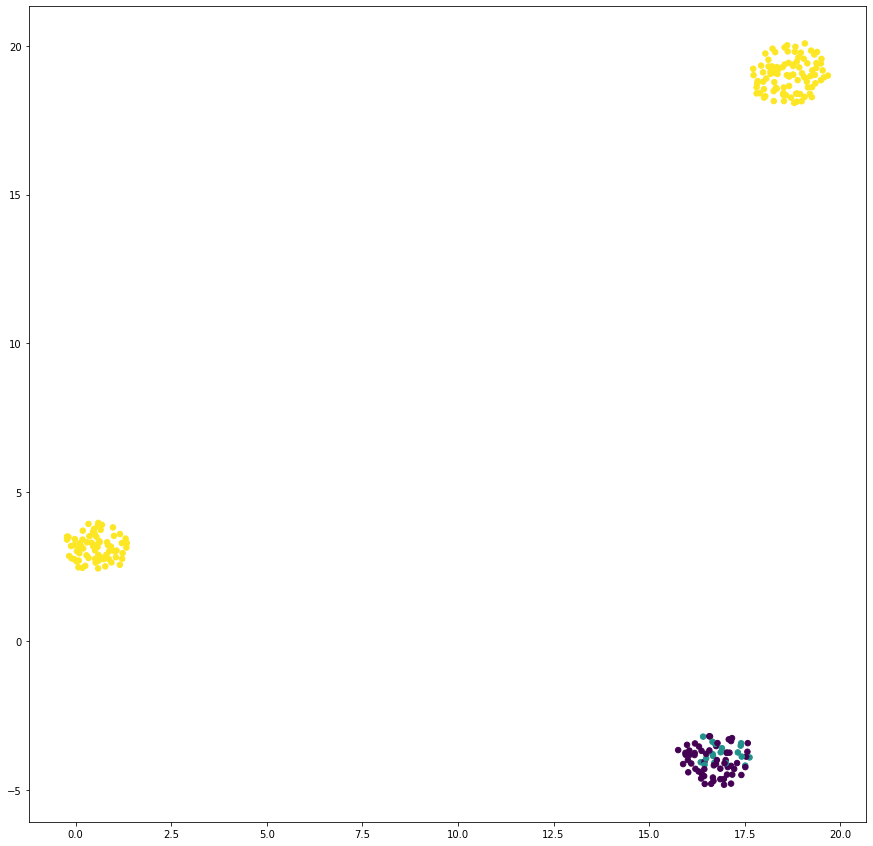

In [313]:
clustering_flag = 0
clustering_flag = int(input("Clustering (1 : K-menas / 2: K-shape / 3 : DBSCAN / 4 : ISODATA) :  "))

# 1 : K-menas / 2 : K-shape / 3 : DBSCAN / 4 : ISODATA(ISODATA 수정해야함)

if clustering_flag == 1:

  MAX_CLUSTER_SIZE = int(input("MAX_CLUSTER_SIZE : "))
  clustering_KMEANS(embedding_data,MAX_CLUSTER_SIZE)


elif clustering_flag == 2:
  MAX_CLUSTER_SIZE = int(input("MAX_CLUSTER_SIZE : "))
  draw_inertia_kshape(dataset,MAX_CLUSTER_SIZE)
  
  N_CLUSTERS = int(input("N_CLUSTERS : "))

  predict = clustering_KSHAPE(dataset,n_cluster=N_CLUSTERS)
  draw_vector_data(embedding_data,predict)

elif clustering_flag == 3:
  EPS = float(input("EPS : "))
  MIN_SAMPLES = int(input("MIN_SAMPLES : "))

  predict = clsutering_DBSCAN(embedding_data,EPS,MIN_SAMPLES)

  draw_vector_data(embedding_data,predict)

elif clustering_flag == 4:

  predict = clustering_ISODATA(embedding_data)
  draw_vector_data(embedding_data,predict)
else :
  pass

In [ ]:
predict